##  lab칼라를 이용한 흑백사진을 컬러로 변경 - https://arxiv.org/pdf/1603.08511.pdf
- https://gitlab-student.centralesupelec.fr/2019melhems/colorization_deep_learning
- https://api.mtr.pub/nilboy/colorization-tf

## 이미지 색상의 이해
https://helpx.adobe.com/kr/photoshop/using/color-modes.html

- Lab 컬러시스템 이해하기
- L (Luminosity) - 명도, 이미지의 밝기
- a - 빨강 / 초록의 보색(a complementary color)축
- b - 노랑 / 파랑의 보색(a complementary color)축
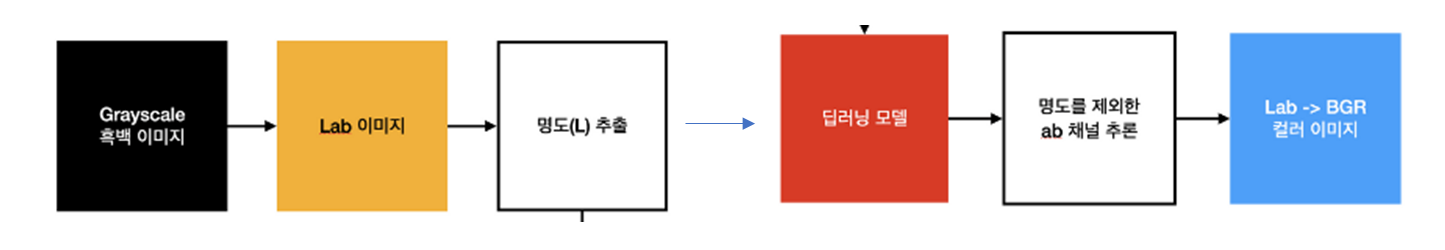

- BGR과 마찬가지로 Lab 또한 이미지를 표현하는 하나의 체계인데 디자이너들이 여러 종류의 모니터로 같은 사진을 볼 때 차이가 없도록 하기 위해 고안되었다고 한다.
- 이미지의 명도 값(L)을 추출해내고, 명도 값을 모델에 넣어 나머지 ab 채널의 값을 추론할 것이다.
- 그리고 추론한 ab 값과 명도 값을 합쳐서 완전한 Lab 이미지를 만들어내고
- 그걸 다시 BGR 컬러 시스템으로 바꿔서 우리가 볼 수 있게 만들 것이다.
- 이미지의 색상 표현은 RGB에 국한되지 않습니다. 예를 들어 이미지 채색 문제에서 LAB는 이미지 채색 문제에 대한 보다 일반적인 색 공간입니다.
- L은 밝기를 나타내고, b는 녹색-빨간색 및 파란색-노란색의 색상 스펙트럼을 나타냅니다. Lab 인코딩 이미지에는 그레이스케일용 레이어가 하나 있고 3개의 색상 레이어가 2개로 압축되어 있습니다.

- skimage.color.rgb2lab 로 쉽게 변환가능함. 
- https://scikit-image.org/docs/dev/api/skimage.color.html#rgb2lab
- lab 칼라는 채널별 최대값을 [0-100, +-128, +-128]로 가지고  있음

In [177]:
from PIL import Image, ImageFilter
import numpy as np
img=Image.open('test.jpg')
img=np.array(img)
np.shape(img)

(442, 488, 3)

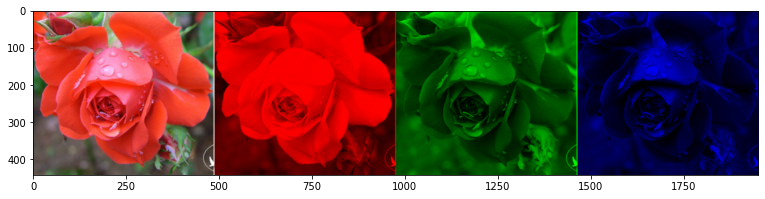

In [178]:
import matplotlib.pyplot as plt
plt.figure(figsize=(13,5))

R,G,B=img*[1,0,0],img*[0,1,0],img*[0,0,1]
plt.imshow(np.concatenate([img,R,G,B], axis=1))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'rgb->lab->rgb')

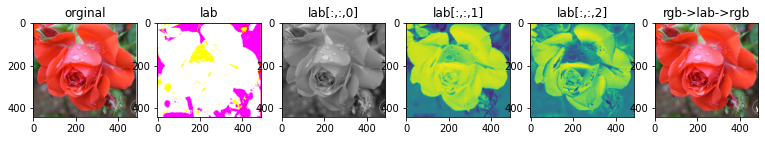

In [256]:
from skimage.color import rgb2lab, lab2rgb
lab=rgb2lab(img)
rgb  =  lab2rgb (lab )

plt.figure(figsize=(13,5))
plt.subplot(1,6,1)
plt.title('orginal')
plt.imshow(img)

plt.subplot(1,6,2)
plt.imshow(np.array(lab))
plt.title('lab')

plt.subplot(1,6,3)
plt.imshow(lab[:,:,0],cmap='gray')
plt.title('lab[:,:,0]')

plt.subplot(1,6,4)
plt.imshow(lab[:,:,1])
plt.title('lab[:,:,1]')

plt.subplot(1,6,5)
plt.imshow(lab[:,:,2])
plt.title('lab[:,:,2]')

plt.subplot(1,6,6)
plt.imshow(img/255)
plt.title('rgb->lab->rgb')

In [341]:
np.shape(img), np.shape(lab), np.shape(rgb)

for x in range(3):
    print(np.shape(lab),lab[:,:,x].min(),'~',lab[:,:,x].max())

print('-'*100)

tmp=np.array(lab)+[0, 128, 128]  # tmp=np.array(lab)+[0, 128, 128] / np.array([100., 255., 255.])  면 원래 lab값 됨
for x in range(3): 
    print(np.shape(tmp),tmp[:,:,x].min(),'~',tmp[:,:,x].max())


(442, 488, 3) 4.887499657419784 ~ 100.0
(442, 488, 3) -50.3409652335598 ~ 75.84980551036425
(442, 488, 3) -39.986706833353125 ~ 67.54493840720093
----------------------------------------------------------------------------------------------------
(442, 488, 3) 4.887499657419784 ~ 100.0
(442, 488, 3) 77.6590347664402 ~ 203.84980551036426
(442, 488, 3) 88.01329316664687 ~ 195.54493840720093


In [137]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense
from keras.models import Sequential

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
from IPython.display import Image

warnings.filterwarnings('ignore')
%matplotlib inline

SEED = 34

In [138]:
# 이미지 로드
data=np.load('pfcn.npz')
train_images=data['train_images']
test_images=data['test_images']


In [139]:
## 흑백이미지 x값 생성
from skimage import color
train_gray_images = np.array([color.rgb2gray(img).reshape((100, 75, 1)) for img in train_images])
test_gray_images = np.array([color.rgb2gray(img).reshape((100, 75, 1)) for img in test_images])

print(train_gray_images.shape, test_gray_images.shape)


(1700, 100, 75, 1) (300, 100, 75, 1)


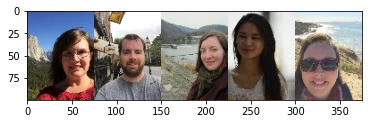

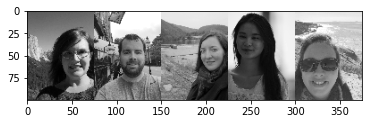

In [140]:
plt.imshow(np.hstack(train_images[:5]))
plt.show()

plt.imshow(np.hstack(train_gray_images[:5]), cmap='gray')
plt.show()

In [141]:
# input (100, 75, 1), output (100, 75, 3)을 처리할 수 있는 모래시계 모양의 모델을 작성하세요.
from keras.layers import Dense, Input, Conv2D, Conv2DTranspose, Flatten, Reshape, MaxPool2D
from keras.models import Model
from keras.layers import BatchNormalization, Dropout, Activation, concatenate

def conv2d_block(x, channel):
    x = Conv2D(channel, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(channel, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x
    
def unet_color():
    inputs = Input((100, 75, 1))

    c1 = conv2d_block(inputs, 16)
    p1 = MaxPool2D(2)(c1)
    p1 = Dropout(0.1)(p1)

    c2 = conv2d_block(p1, 32)
    p2 = MaxPool2D(2)(c2)
    p2 = Dropout(0.1)(p2)

    c3 = conv2d_block(p2, 64)
    p3 = MaxPool2D(2)(c3)
    p3 = Dropout(0.1)(p3)

    c4 = conv2d_block(p3, 128)
    p4 = MaxPool2D(2)(c4)
    p4 = Dropout(0.1)(p4)

    c5 = conv2d_block(p4, 256)

    u6 = Conv2DTranspose(128, 2, 2, padding="valid", output_padding=(0,1))(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(0.1)(u6)
    c6 = conv2d_block(u6, 128)

    u7 = Conv2DTranspose(64, 2, 2, padding="valid", output_padding=(1,0))(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(0.1)(u7)
    c7 = conv2d_block(u7, 64)

    u8 = Conv2DTranspose(32, 2, 2, padding="valid", output_padding=(0,1))(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(0.1)(u8)
    c8 = conv2d_block(u8, 32)

    u9 = Conv2DTranspose(16, 2, 2, padding="valid", output_padding=(0,1))(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(0.1)(u9)
    c9 = conv2d_block(u9, 16)

    outputs = Conv2D(3, 1, activation="sigmoid")(c9)
    model = Model(inputs, outputs)
    return model

In [142]:
# unet_color() 모델을 할당 받고 서머리를 출력하는 코드를 작성하세요.
model = unet_color()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 75, 1)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 100, 75, 16)  160         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 100, 75, 16)  64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 100, 75, 16)  0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [143]:
model.compile(loss = "mse", optimizer="adam", metrics=["accuracy"])
hist = model.fit(train_gray_images, train_images, 
                 validation_data=(test_gray_images, test_images), 
                 epochs=50, verbose=1)

Epoch 1/50
54/54 [==============================] - 15s 100ms/step - loss: 0.0413 - accuracy: 0.4286 - val_loss: 0.0790 - val_accuracy: 0.6189
Epoch 2/50
54/54 [==============================] - 2s 35ms/step - loss: 0.0173 - accuracy: 0.5284 - val_loss: 0.0702 - val_accuracy: 0.6892
Epoch 3/50
54/54 [==============================] - 2s 35ms/step - loss: 0.0125 - accuracy: 0.5866 - val_loss: 0.0665 - val_accuracy: 0.6892
Epoch 4/50
54/54 [==============================] - 2s 35ms/step - loss: 0.0102 - accuracy: 0.6117 - val_loss: 0.0572 - val_accuracy: 0.6892
Epoch 5/50
54/54 [==============================] - 2s 35ms/step - loss: 0.0088 - accuracy: 0.6154 - val_loss: 0.0456 - val_accuracy: 0.6892
Epoch 6/50
54/54 [==============================] - 2s 35ms/step - loss: 0.0085 - accuracy: 0.6228 - val_loss: 0.0339 - val_accuracy: 0.6312
Epoch 7/50
54/54 [==============================] - 2s 35ms/step - loss: 0.0080 - accuracy: 0.6254 - val_loss: 0.0251 - val_accuracy: 0.5500
Epoch 8/50


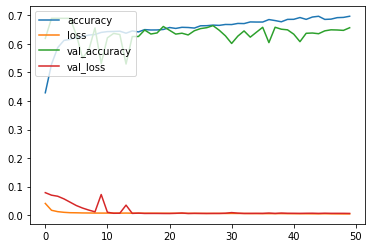

In [144]:
plt.plot(hist.history['accuracy'], label='accuracy')
plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_accuracy'], label='val_accuracy')
plt.plot(hist.history['val_loss'], label='val_loss')
plt.legend(loc='upper left')
plt.show()

(1, 100, 75, 1)
(1, 100, 75, 3)


Text(0.5, 1.0, 'ai')

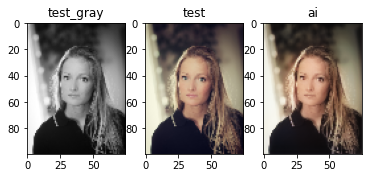

In [145]:
# 모델에 test_gray_images 중 1장을 넣고 결과를 받아 실행
res = model.predict(test_gray_images[2:3])
print(test_gray_images[2:3].shape)
print(res.shape)

plt.subplot(1,3,1)
plt.imshow(test_gray_images[2],cmap='gray')
plt.title('test_gray')

plt.subplot(1,3,2)
plt.imshow(test_images[2])
plt.title('test')

plt.subplot(1,3,3)
plt.imshow(res[0])
plt.title('ai')

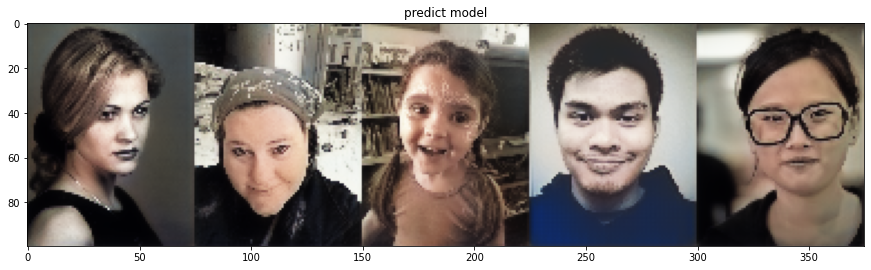

Text(0.5, 1.0, 'gray')

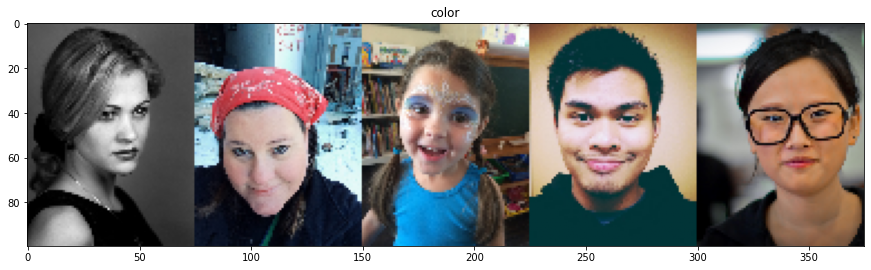

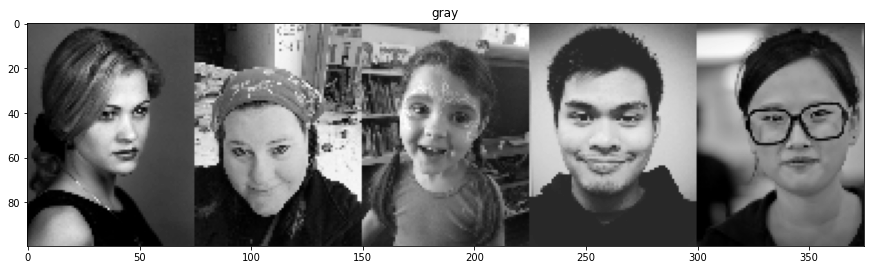

In [156]:
plt.figure(figsize=(15,5))
five = model.predict(test_gray_images[10:15])

plt.imshow(np.hstack(five))
plt.title('predict model')
plt.show()

plt.figure(figsize=(15,5))
plt.imshow(np.hstack(test_images[10:15]))
plt.title('color')


plt.figure(figsize=(15,5))
plt.imshow(np.hstack(test_gray_images[10:15]),cmap='gray')
plt.title('gray')

#### lab 칼라를 이용하여서 색상변경

In [157]:
## Step 6. lab 칼라 모델링
# rgb2lab을 이용하여 rgb 칼라를 lab 칼라로 바꾸는 코드를 작성하세요.
train_lab_images = np.array([color.rgb2lab(img) for img in train_images])
test_lab_images = np.array([color.rgb2lab(img) for img in test_images])

In [227]:
train_lab_images = (train_lab_images + [0, 128, 128]) / [100., 255., 255.]
test_lab_images = (test_lab_images + [0, 128, 128]) / [100., 255., 255.]

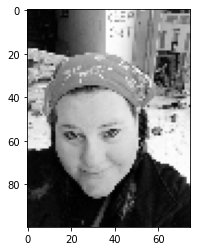

0.0 1.0
0.19397112017382181 0.8400303209378147
0.14128202093029715 0.8698299619820618


(1700, 100, 75, 3)

In [232]:
plt.imshow(test_lab_images[11][...,0], cmap="gray")
plt.show()     
#np.shape(test_lab_images),np.shape(test_lab_images)

print(train_lab_images[...,0].min(), train_lab_images[...,0].max())
print(train_lab_images[...,1].min(), train_lab_images[...,1].max())
print(train_lab_images[...,2].min(), train_lab_images[...,2].max())


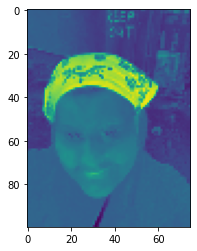

In [243]:
plt.imshow(test_lab_images[11][...,0:1],cmap='gray')
plt.imshow(test_lab_images[11][...,1:2])

In [231]:
#########################################################################################
## 출력형태가 100,75,2 여야함.
# input (100, 75, 1), output (100, 75, 2)
##########################################################################################
from keras.layers import Dense, Input, Conv2D, Conv2DTranspose, Flatten, Reshape, MaxPool2D
from keras.models import Model
from keras.layers import BatchNormalization, Dropout, Activation, concatenate

from keras.layers import Dense, Input, Conv2D, Conv2DTranspose, Flatten, Reshape, MaxPool2D
from keras.models import Model
from keras.layers import BatchNormalization, Dropout, Activation, concatenate

def conv2d_block(x, channel):
    x = Conv2D(channel, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(channel, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x
    
def unet_lab():
    inputs = Input((100, 75, 1))

    c1 = conv2d_block(inputs, 16)
    p1 = MaxPool2D(2)(c1)
    p1 = Dropout(0.1)(p1)

    c2 = conv2d_block(p1, 32)
    p2 = MaxPool2D(2)(c2)
    p2 = Dropout(0.1)(p2)

    c3 = conv2d_block(p2, 64)
    p3 = MaxPool2D(2)(c3)
    p3 = Dropout(0.1)(p3)

    c4 = conv2d_block(p3, 128)
    p4 = MaxPool2D(2)(c4)
    p4 = Dropout(0.1)(p4)

    c5 = conv2d_block(p4, 256)
    
    u6 = Conv2DTranspose(128, 2, 2, padding="valid", output_padding=(0,1))(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(0.1)(u6)
    c6 = conv2d_block(u6, 128)

    u7 = Conv2DTranspose(64, 2, 2, padding="valid", output_padding=(1,0))(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(0.1)(u7)
    c7 = conv2d_block(u7, 64)

    u8 = Conv2DTranspose(32, 2, 2, padding="valid", output_padding=(0,1))(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(0.1)(u8)
    c8 = conv2d_block(u8, 32)

    u9 = Conv2DTranspose(16, 2, 2, padding="valid", output_padding=(0,1))(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(0.1)(u9)
    c9 = conv2d_block(u9, 16)

    outputs = Conv2D(2, 1, activation="sigmoid")(c9)
    model = Model(inputs, outputs)
    return model

In [233]:
model2 = unet_lab()
model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 100, 75, 1)] 0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 100, 75, 16)  160         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_18 (BatchNo (None, 100, 75, 16)  64          conv2d_19[0][0]                  
__________________________________________________________________________________________________
activation_18 (Activation)      (None, 100, 75, 16)  0           batch_normalization_18[0][0]     
____________________________________________________________________________________________

In [257]:
model2.compile(loss="mae", optimizer="adam", metrics=["accuracy"])
hist2 = model2.fit(train_lab_images[...,0:1], train_lab_images[...,1:], 
                   validation_data=(test_lab_images[...,0:1], test_lab_images[...,1:]), epochs=50, verbose=1)

Epoch 1/50
54/54 [==============================] - 5s 47ms/step - loss: 0.0511 - accuracy: 0.5398 - val_loss: 0.0403 - val_accuracy: 0.5912
Epoch 2/50
54/54 [==============================] - 2s 36ms/step - loss: 0.0355 - accuracy: 0.5988 - val_loss: 0.0423 - val_accuracy: 0.5981
Epoch 3/50
54/54 [==============================] - 2s 35ms/step - loss: 0.0351 - accuracy: 0.6087 - val_loss: 0.0419 - val_accuracy: 0.5981
Epoch 4/50
54/54 [==============================] - 2s 36ms/step - loss: 0.0346 - accuracy: 0.6088 - val_loss: 0.0463 - val_accuracy: 0.5981
Epoch 5/50
54/54 [==============================] - 2s 36ms/step - loss: 0.0336 - accuracy: 0.6154 - val_loss: 0.0651 - val_accuracy: 0.5981
Epoch 6/50
54/54 [==============================] - 2s 36ms/step - loss: 0.0329 - accuracy: 0.6162 - val_loss: 0.0681 - val_accuracy: 0.5942
Epoch 7/50
54/54 [==============================] - 2s 37ms/step - loss: 0.0327 - accuracy: 0.6167 - val_loss: 0.0491 - val_accuracy: 0.6092
Epoch 8/50
54

In [ ]:

plt.plot(hist.history['accuracy'], label='accuracy')
plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_accuracy'], label='val_accuracy')
plt.plot(hist.history['val_loss'], label='val_loss')
plt.legend(loc='upper left')
plt.show()

In [ ]:
res = model2.predict(test_lab_images[1:2][...,0:1])

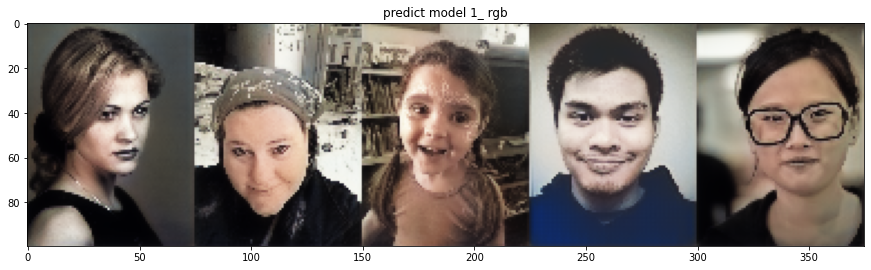

In [260]:
plt.figure(figsize=(15,5))
five1 = model.predict(test_gray_images[10:15])
plt.imshow(np.hstack(five1))
plt.title('predict model 1_ rgb')
plt.show()




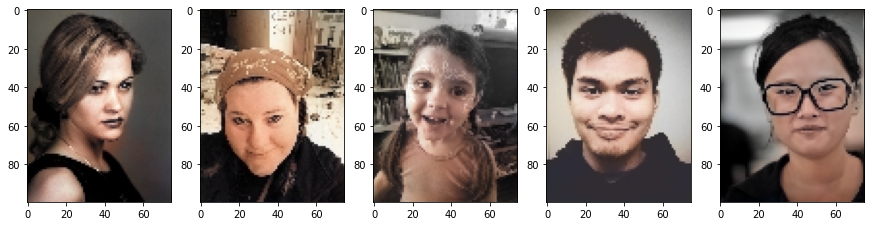

In [266]:
plt.figure(figsize=(15,5))
def l2rgb(imgArr):
    pred_ab = model2.predict(np.expand_dims(imgArr, 0))
    pred_img = np.zeros((100, 75, 3))

    pred_img[:,:,0] = imgArr.reshape((100,75))
    pred_img[:,:,1:] = pred_ab[0]
    
    pred_lab = (pred_img * [100, 255, 255]) - [0, 128, 128]
    rgb_img = color.lab2rgb(pred_lab)
    return rgb_img


for cnt,x in enumerate(range(10,15)):
    plt.subplot(1,5,cnt+1)
    plt.imshow(l2rgb(test_lab_images[x][...,0]) )


In [299]:
test_images[10].min(),test_images[10].max()

(0.0, 0.9794117647058828)

In [329]:
np.shape(test), test.min(),test.max()

((100, 75, 3), 0.10588235294117647, 1.0)

###  인물사진 위주의 흑백사진을 넣어서 컬러 사진으로 변경하여 보세요